# Central SHMR Scatter Plot

In [1]:
# python 3.6.7
import numpy as np  # has to be upgraded to v1.19.5 for compatibility with loess
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm.contrib.concurrent import process_map
from loess.loess_2d import loess_2d # has to be the v2.0.11 for compatibility with numpy
import datetime
import h5py
from tqdm import tqdm
from multiprocessing import Pool
from itertools import repeat
from functools import partial

import illustris_python as il

print(np.version.version)

1.24.3


In [4]:
# load cosmology data
with h5py.File("cosmology.hdf5", "r") as file:
    time = np.array(file["t"])
    redshift = np.array(file["z"])

In [5]:
# load data
with h5py.File("halo_properties.hdf5", "r") as file:
    halo_mass = np.array(file["Mh"])
    stellar_mass = np.array(file["Ms"])
    gas_mass = np.array(file["Mg"])
    
baryonic_mass = np.log10(10**stellar_mass + 10**gas_mass)

# calculate formation time for all galaxies (time to accrete half final DM mass)
form_time = np.ndarray(len(halo_mass))
half_mass = halo_mass[:,-1] - np.log10(2)

for i in range(len(half_mass)):
    j = 0
    while halo_mass[i,j] < half_mass[i] or np.isnan(halo_mass[i,j]):
        j += 1
    form_time[i] = redshift[j]
    
print(np.min(form_time), np.max(form_time))
# form_time = np.clip(form_time, 0, 8)

/tmp/ipykernel_517/2783769240.py:7: RuntimeWarning: divide by zero encountered in log10
  baryonic_mass = np.log10(10**stellar_mass + 10**gas_mass)


2.220446049250313e-16 5.5297658079491026


Smoothing out the noise in the scatter using `loess`.

In [7]:
start = datetime.datetime.now()
smoothed_form_time, _ = loess_2d(halo_mass[:,-1], stellar_mass[:,-1], form_time, npoints=100)
end = datetime.datetime.now()

print(end - start)
smoothed_form_time = np.clip(smoothed_form_time, 0, None)
with h5py.File("smoothed_form_time.hdf5", "w") as file:
    file.create_dataset("form_time", data=smoothed_form_time)

0:00:30.082909


In [8]:
with h5py.File("smoothed_form_time.hdf5", "r") as file:
    smoothed_form_time = np.array(file["form_time"])

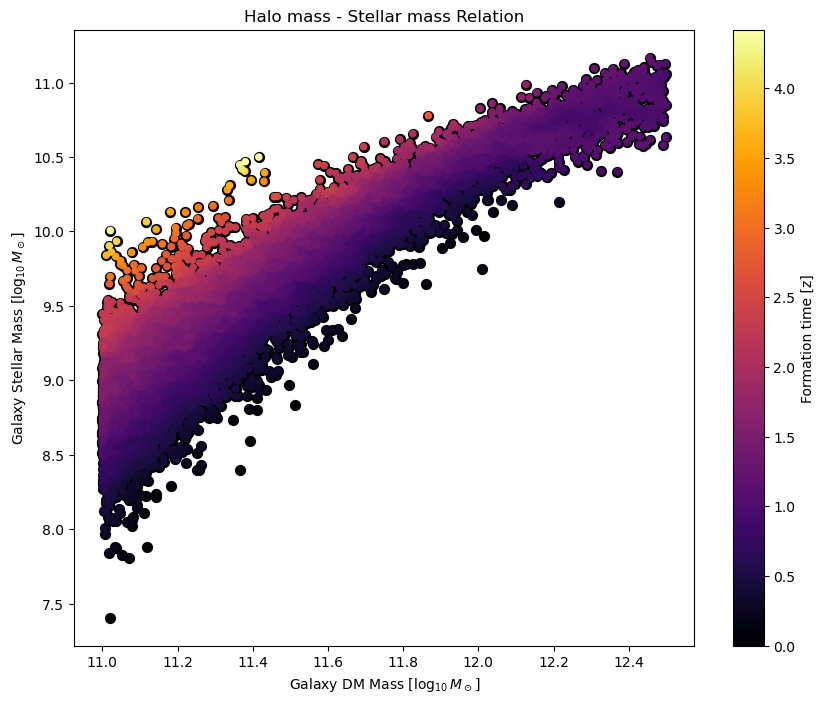

In [11]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

plt.scatter(halo_mass[:,-1], stellar_mass[:,-1], marker="o", s=50, c="black")
plt.scatter(halo_mass[:,-1], stellar_mass[:,-1], marker="o", s=20, c=smoothed_form_time, cmap="inferno")

ax.set_title("Halo mass - Stellar mass Relation")
ax.set_xlabel("Galaxy DM Mass [$\log_{10}M_\odot$]")
ax.set_ylabel("Galaxy Stellar Mass [$\log_{10}M_\odot$]")

# typical mass limits
# plt.ylim(8, 12) # stellar mass
# plt.xlim(9, 13) # halo

# colourmap
cb = plt.colorbar()
cb.set_label("Formation time [z]")

Want to look at the scatter plots of the other mass components to see if there is any correlation of formation time with scatter there.

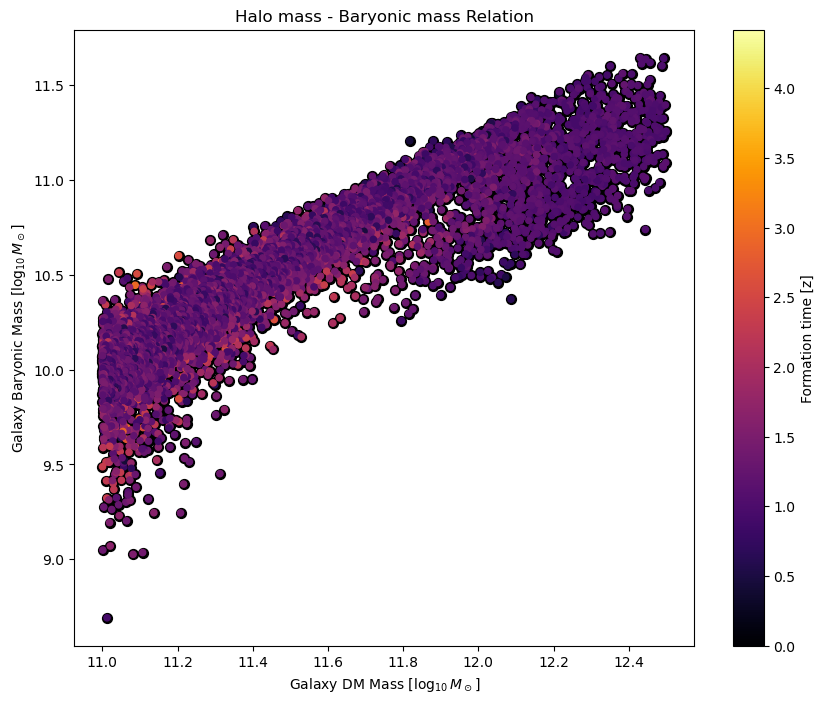

In [13]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

plt.scatter(halo_mass[:,-1], baryonic_mass[:,-1], marker="o", s=50, c="black")
plt.scatter(halo_mass[:,-1], baryonic_mass[:,-1], marker="o", s=20, c=smoothed_form_time, cmap="inferno")

ax.set_title("Halo mass - Baryonic mass Relation")
ax.set_xlabel("Galaxy DM Mass [$\log_{10}M_\odot$]")
ax.set_ylabel("Galaxy Baryonic Mass [$\log_{10}M_\odot$]")

# typical mass limits
# plt.ylim(8, 12) # stellar mass
# plt.xlim(9, 13) # halo

# colourmap
cb = plt.colorbar()
cb.set_label("Formation time [z]")

# fig.savefig("bhmr")

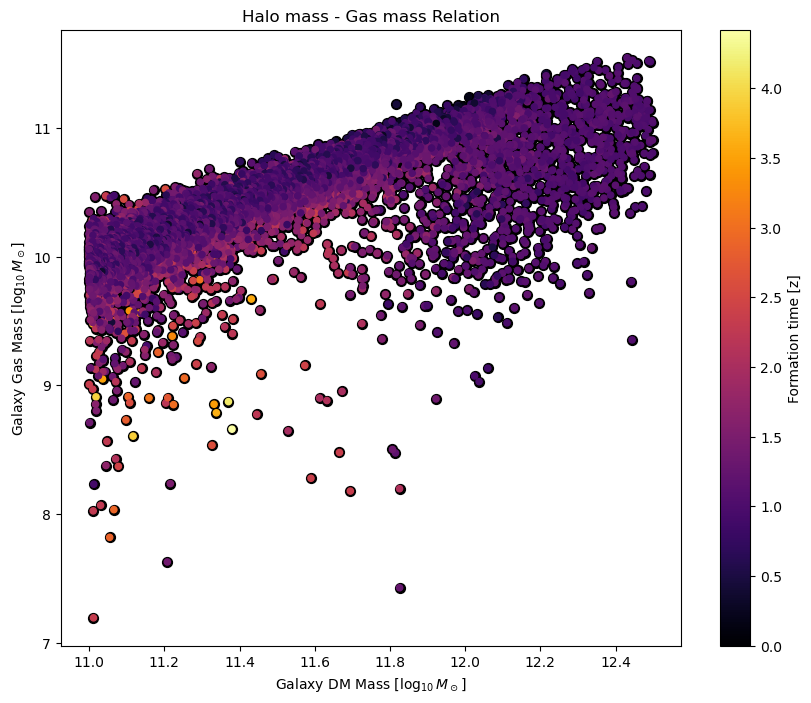

In [14]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

plt.scatter(halo_mass[:,-1], gas_mass[:,-1], marker="o", s=50, c="black")
plt.scatter(halo_mass[:,-1], gas_mass[:,-1], marker="o", s=20, c=smoothed_form_time, cmap="inferno")

ax.set_title("Halo mass - Gas mass Relation")
ax.set_xlabel("Galaxy DM Mass [$\log_{10}M_\odot$]")
ax.set_ylabel("Galaxy Gas Mass [$\log_{10}M_\odot$]")

# typical mass limits
# plt.ylim(8, 12) # stellar mass
# plt.xlim(9, 13) # halo

# colourmap
cb = plt.colorbar()
cb.set_label("Formation time [z]")